In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## 3-1. CC & AARRR

In [ ]:
tb = pd.read_csv('bootcamp_chapter3-1_data.csv')
tb

### 1) 코호트 차팅 후 리텐션을 정의해보세요

In [122]:
df = tb[tb.approved_dt.notnull()]
df['approved_dt'] = df['approved_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

C:\Users\seongbin\AppData\Local\Temp\ipykernel_23232\104951480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['approved_dt'] = df['approved_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))


In [123]:
# 결제 월과 코호트 월 생성
df["transaction_week"] = df["approved_dt"].dt.to_period("W")
df["cohort_week"] = df.groupby("customer_id")["transaction_week"].transform("min")

C:\Users\seongbin\AppData\Local\Temp\ipykernel_23232\3473977348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transaction_week"] = df["approved_dt"].dt.to_period("W")
C:\Users\seongbin\AppData\Local\Temp\ipykernel_23232\3473977348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cohort_week"] = df.groupby("customer_id")["transaction_week"].transform("min")


In [124]:
# 코호트 기간 계산
df["period"] = (df["transaction_week"] - df["cohort_week"]).apply(lambda x: x.n)

C:\Users\seongbin\AppData\Local\Temp\ipykernel_23232\3694907850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["period"] = (df["transaction_week"] - df["cohort_week"]).apply(lambda x: x.n)


In [125]:
# 코호트 테이블 생성
cohort_table = df.groupby(["cohort_week", "period"])["customer_id"].nunique().unstack(fill_value=0)

In [126]:
# 상대적 비율 계산 (최초 월 대비 유지율)
cohort_size = cohort_table.iloc[:, 0]
retention_table = cohort_table.divide(cohort_size, axis=0)

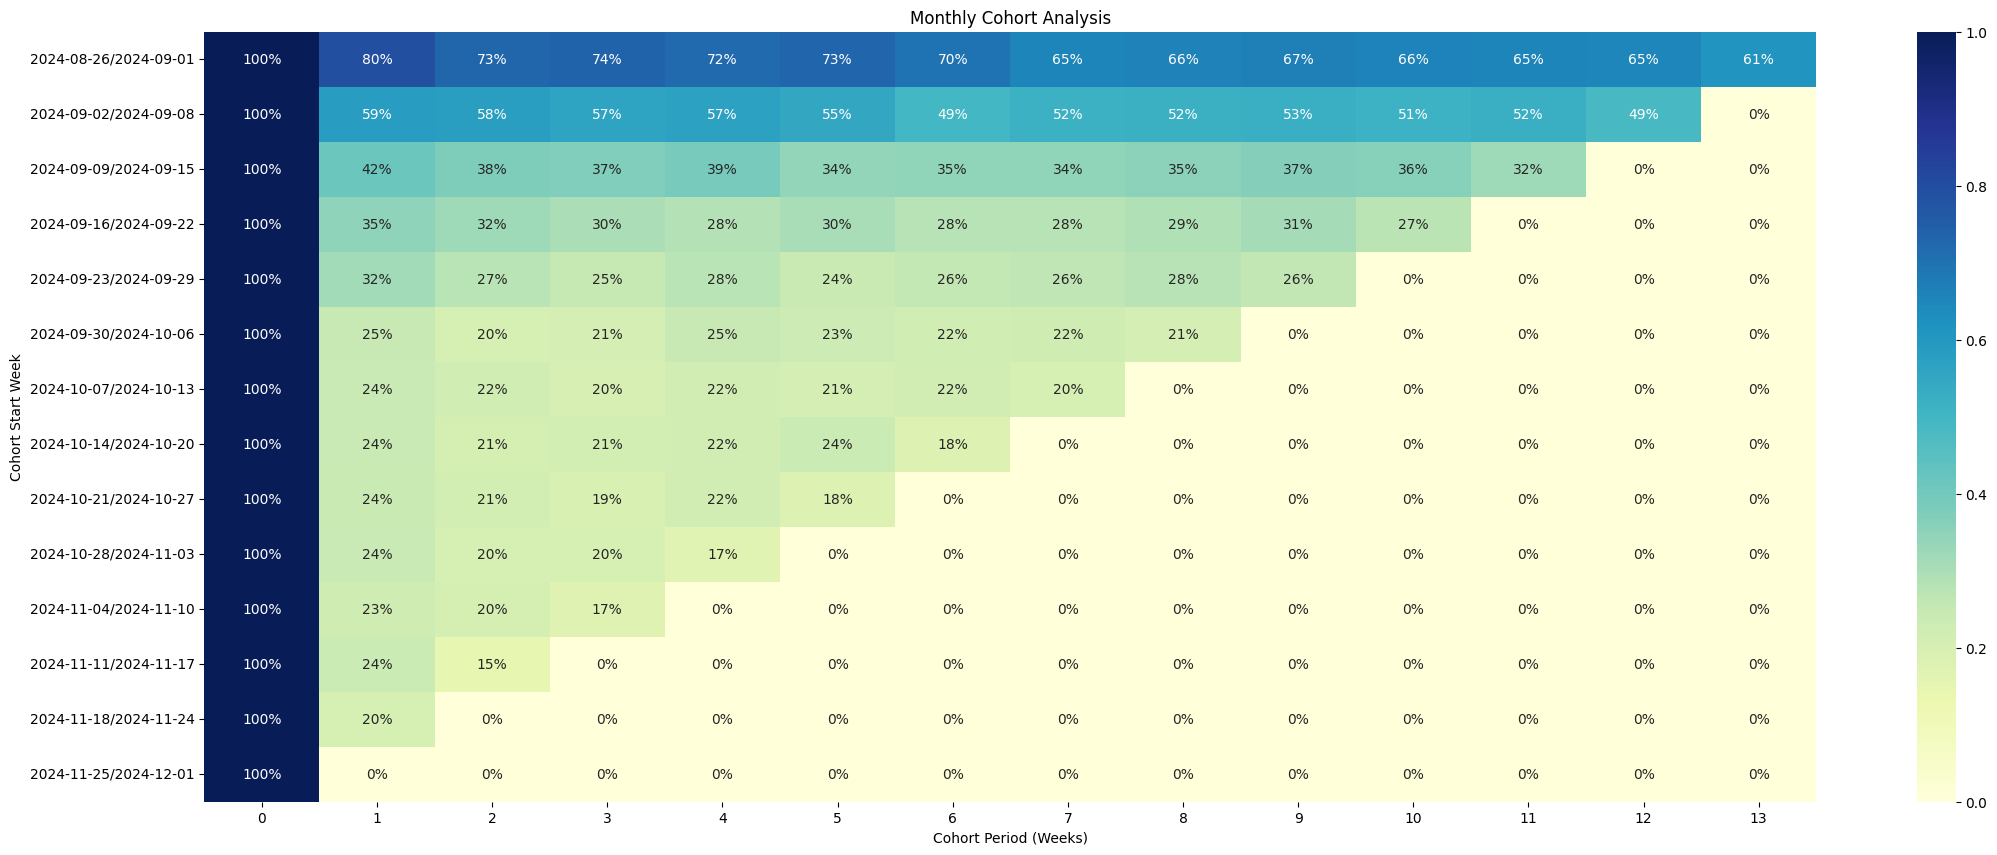

In [127]:
# 시각화
plt.figure(figsize=(26, 10))
sns.heatmap(retention_table, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Monthly Cohort Analysis")
plt.xlabel("Cohort Period (Weeks)")
plt.ylabel("Cohort Start Week")
plt.show()

### 2) Inflow와 리텐션 및 이탈률을 구하고, cc를 계산해보세요

In [182]:
#주평균 획득(Acquisition) 유저 수 구하기
tb['join_week'] = tb['join_dt'].dt.to_period('W')
inflow_tmp = tb.groupby('join_week').customer_id.nunique().reset_index()
inflow_tmp

,join_week,customer_id
0,2019-04-01/2019-04-07,30483
1,2019-04-08/2019-04-14,363
2,2019-04-15/2019-04-21,315
3,2019-04-22/2019-04-28,448
4,2019-04-29/2019-05-05,363
...,...,...
274,2024-07-01/2024-07-07,6
275,2024-07-08/2024-07-14,9
276,2024-07-15/2024-07-21,5
277,2024-07-22/2024-07-28,4


<Axes: >

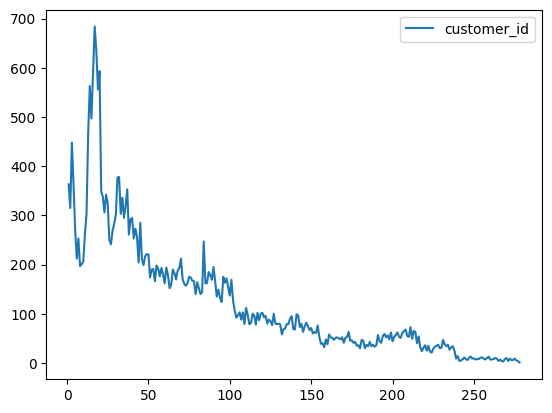

In [186]:
sns.lineplot(inflow_tmp.loc[1:, :])

In [201]:
inflow = inflow_tmp.customer_id.mean()

In [202]:
tmp = df.groupby('customer_id').approved_dt.min().reset_index()
tmp = tmp[tmp['approved_dt']<'2024-10-28']
tmp2 = df[df.customer_id.isin(tmp.customer_id.unique())]

retention_tmp = tmp2.groupby('period').customer_id.nunique() / tmp2.customer_id.nunique()
retention_tmp = retention_tmp.reset_index()

In [203]:
retention_tmp

,period,customer_id
0,0,1.000000
1,1,0.485160
2,2,0.455754
3,3,0.444893
4,4,0.450814
5,5,0.435444
6,6,0.400706
7,7,0.398118
8,8,0.392550
9,9,0.385885


<Axes: xlabel='period', ylabel='customer_id'>

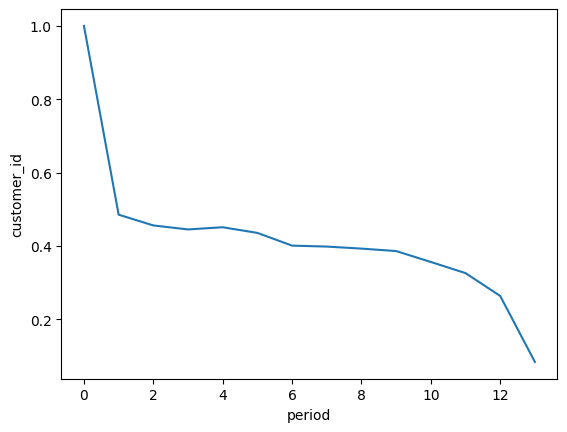

In [204]:
sns.lineplot(retention_tmp, x='period', y='customer_id')

In [206]:
#Retention 구하기
retention = retention_tmp.loc[1][1]

#cc 구하기
cc = inflow / (1-retention)

print('# of users acquire: {}'.format(inflow))
print('retention_rate: {}'.format(retention))
print('cc: {}'.format(cc))

# of users acquire: 230.14336917562724
retention_rate: 0.4851597725936091
cc: 447.019010800729


C:\Users\seongbin\AppData\Local\Temp\ipykernel_23232\1211402360.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  retention = retention_tmp.loc[1][1]


## 3-2. A/B Test

### 1) 퍼널 분석
- 당신은 대출중개플랫폼의 신용대출 제품 DA입니다.
- 최근 대출 실행률(대출 실행 / 대출신청)이 감소하는 것을 대시보드를 통해서 확인했습니다.
- 문제를 찾던 도중, 특정 제휴사의 대출실행률이 유난히 떨어지는 것을 발견했습니다.
- 해당 제휴사의 대출 실행 퍼널 중 **어떤 퍼널에서 문제가 발생한 것**인지 분석해보세요.

 A: 본인인증 >> B: 신분증인증 >> C: 개인정보입력 >> D: 대출 조건 기입(상환방법, 상환기간, 대출금액 등) >> E: 대출 심사 >> F: 대출 실행

In [209]:
funnel_df = pd.read_csv('bootcamp_chapter3-2_data.csv')

In [214]:
agg_funnel = funnel_df.groupby('screen_name').user_id.nunique().reset_index()
agg_funnel.rename(columns={'user_id': 'user_cnt'}, inplace=True)
agg_funnel['conversion'] = agg_funnel['user_cnt'] / agg_funnel.loc[0, 'user_cnt']

In [223]:
agg_funnel

,screen_name,user_cnt,conversion
0,A,10000,1.0000
1,B,8024,0.8024
2,C,2482,0.2482
3,D,2213,0.2213
4,E,1762,0.1762
5,F,1218,0.1218


### 2) 문제 정의 & 실험
- 당신은 신분증 인증 화면에서 대다수의 유저가 이탈하는 것을 팀의 PO(Product Owner)와 FE(프론트 개발자)에게 리포팅 했습니다.
- 확인 결과, 제휴사가 사용하는 신분증 촬영 & 인식 솔루션에 심각한 결함이 있는 것을 확인했고, 제휴사는 결함 해결을 위한 개발 작업에 착수했습니다.
- PD(Product Designer)는 이 참에 UX 개선도 함께 할 것을 제안하였고 팀원 모두가 이에 대해 동의했습니다.
- 당신은 실험군과 대조군을 나눠 각각의 그룹에게 다른 화면을 보여주는 실험을 설계했고, 제휴사 측에서 실험까지 반영해서 웹을 재배포 했습니다.
- **실험 결과**를 분석해주세요.

- 실험군: 화면 A 노출 유저
- 대조군: 기존 화면 노출 유저
- 개선지표: C 화면 도달률

In [232]:
abtest_df = pd.read_csv('bootcamp_chapter3-2_data2.csv')

In [233]:
abtest_df.groupby(['group', 'screen_name']).user_id.nunique()

group  screen_name
A      A              10000
       B               7610
       C               3952
       D               3555
       E               2836
       F               2017
B      A              10000
       B               7914
       C               2735
       D               2424
       E               1945
       F               1363
Name: user_id, dtype: int64

In [241]:
scr_b = abtest_df[abtest_df['screen_name']=='B'][['user_id', 'group']]
scr_c = abtest_df[abtest_df['screen_name']=='C'][['user_id', 'group']]
scr_c['exp_c_yn'] = 1

In [243]:
abtest = pd.merge(scr_b, scr_c, how='left', on=['user_id', 'group'])
abtest.fillna(0, inplace=True)

In [245]:
contingency_table = pd.crosstab(abtest['group'], abtest['exp_c_yn'])

# 카이제곱 검정
chi2_stat, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)

# 결과 출력
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value_chi2}")
print(f"Degrees of freedom: {dof}")

Chi-squared statistic: 476.7999012015489
P-value: 1.0618980557855838e-105
Degrees of freedom: 1


In [249]:
conv_a = abtest[abtest['group']=='A'].exp_c_yn.sum() / abtest[abtest['group']=='A'].user_id.nunique()
conv_b = abtest[abtest['group']=='B'].exp_c_yn.sum() / abtest[abtest['group']=='B'].user_id.nunique()

In [261]:
print(f"A안 전환율: {round(conv_a*100, 2)}%")
print(f"B안 전환율: {round(conv_b*100, 2)}%")
print(f"전환율 개선율: {round((conv_a - conv_b) / conv_b * 100, 2)}%")

A안 전환율: 51.93%
B안 전환율: 34.56%
전환율 개선율: 50.27%


## 3-3. ML

### 1) 역할 설정
- 당신은 금융플랫폼 회사에서 보험 중개 제품을 맡은 데이터 분석가입니다
- 당신의 보험 제품에는 총 5가지 서비스가 있으며, 모든 서비스는 제휴사 가입 퍼널로 이어지도록 만들어져 있습니다
- 당신의 팀은 어떤 서비스를 전면에 내세워야 할지 고민하고 있으며, 비즈니스 성과에 각 서비스들이 얼마나 기여하는지 궁금해 하고 있습니다.
- 어떤 서비스를 제품의 핵심 서비스로 키울지에 대한 분석 인사이트를 SHAP으로 만들어 보세요

### 2) Data
- 데이터는 일자 및 서비스 별 방문자 수가 있습니다
- bnft_user_cnt: 유저의 행동에 따라 리워드를 지급하는 혜택성 지면입니다. (마이데이터 가입시 n원, 보험 상품 조회시 n원 등)
- lck_comp_user_cnt: 유저의 보험료와 보장 데이터를 활용하여 가입한 보험의 가성비를 평가해주는 지면입니다.
- bridge_user_cnt: 외부 채널에서 유저의 보험 가입을 위한 마케팅을 할 때, 유저를 랜딩 시키는 브릿지 화면입니다. 버튼을 누르는 즉시 보험 가입 페이지로 이동하며 보험 가입을 완료하면 리워드를 받을 수 있는 혜택성 지면입니다.
- detail_user_cnt: 유저의 보험 정보를 조회할 수 있는 정보성 지면입니다. (보험료, 보장내역, 가입정보 등)
- r_fee_user_cnt: 유저의 보험금을 보험 대리점을 통해 청구할 수 있는 보험금 간편 청구 서비스 지면입니다.
- cm_user_cnt: 보험 가입 지면입니다. (종속변수)

### 3) Analyzation & Visualization Guide
- 3가지 그래프를 차팅하세요(변수별 기여도(영향도)를 확인할 수 있는 차트, 변수 값의 크기에 따라 shap_value를 확인할 수 있는 차트, Dependence Plot)
- 3가지 그래프를 활용해 어떤 서비스를 제품 전면에 내세울지 의사결정을 해보세요.
- 타 직무의 팀원들은 ML에 대한 이해도가 없어 Shap 분석을 이해하기 어렵습니다. 가장 성과가 좋았던 날과, 가장 좋지 않았던 날에 대한 Waterfall 차트를 활용해 shap 분석에 대한 개념을 팀원들에게 설명해주세요

In [52]:
import shap
import xgboost

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [60]:
df

,partition_day,bnft_user_cnt,lck_comp_user_cnt,bridge_user_cnt,detail_user_cnt,r_fee_user_cnt,cm_user_cnt
0,2023-07-01,1626,71,4464,82,29,489
1,2023-07-02,1959,86,4882,466,37,525
2,2023-07-03,1360,12,1245,494,42,473
3,2023-07-04,1794,79,4247,228,10,501
4,2023-07-05,1630,81,4110,476,48,515
...,...,...,...,...,...,...,...
179,2023-12-27,689,36,2687,50,23,444
180,2023-12-28,1748,11,2931,436,25,502
181,2023-12-29,1908,99,3737,397,9,511
182,2023-12-30,1900,26,4746,239,22,506


In [53]:
df = pd.read_csv('bootcamp_chapter3-3_data.csv')

In [80]:
#모델링
exp_v = df.iloc[:, 1:6]
tar_v = df[['cm_user_cnt']]

shap.initjs()

model = xgboost.XGBRFRegressor().fit(exp_v, tar_v)

explainer = shap.Explainer(model)
shap_value = explainer(exp_v)

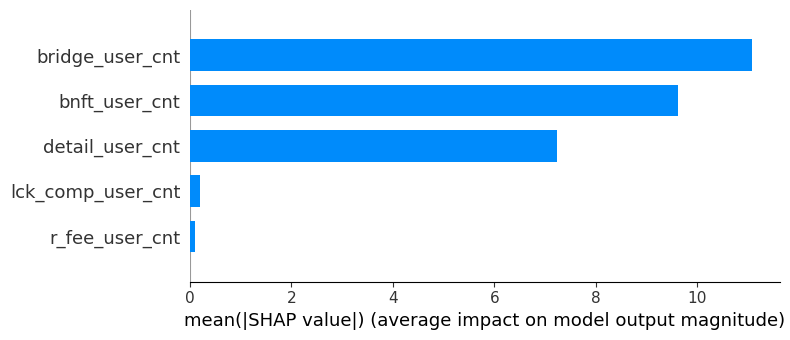

In [81]:
#기여도(중요도) 차팅
shap.summary_plot(shap_value, exp_v, plot_type='bar')

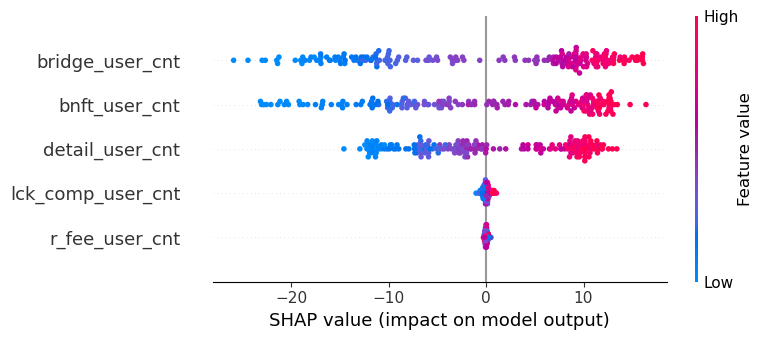

In [82]:
#변수별 shap value 차팅
shap.summary_plot(shap_value, exp_v)

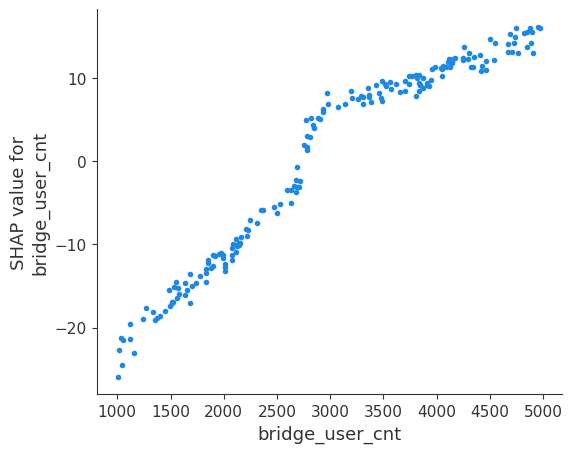

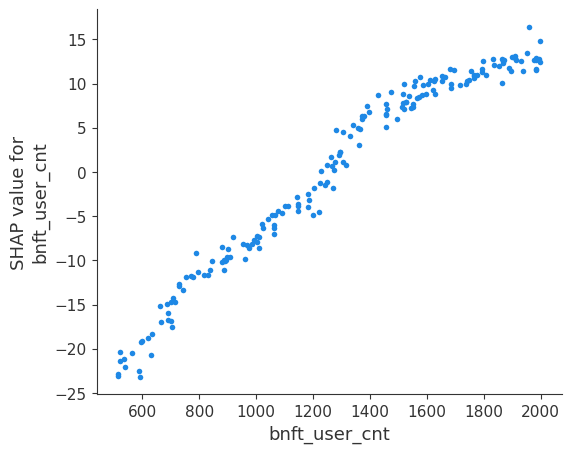

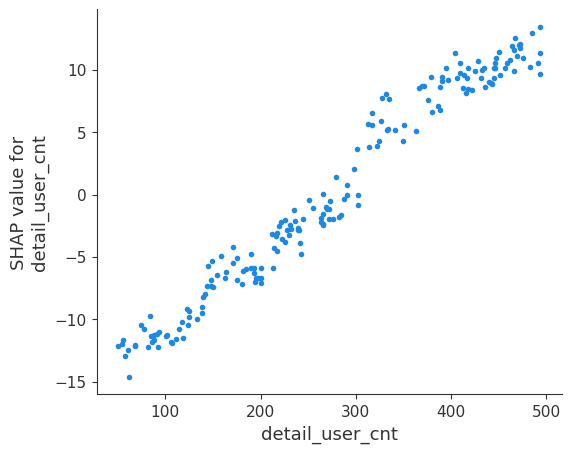

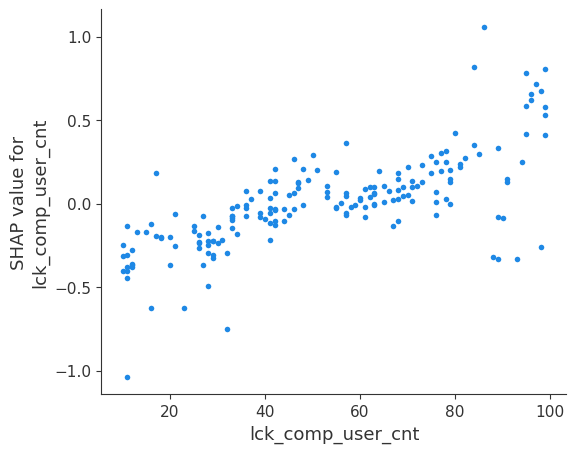

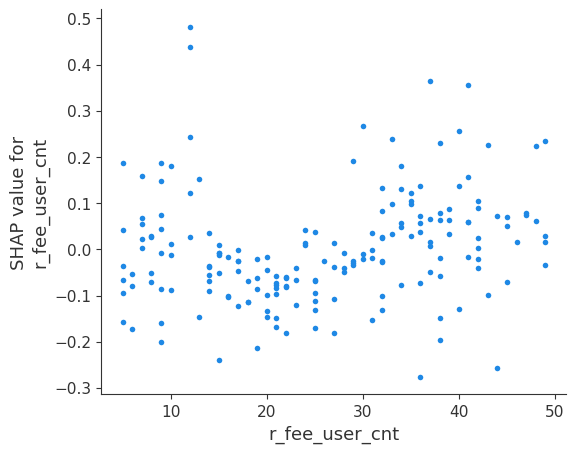

In [59]:
#Dependence Plot 차팅
top_inds = np.argsort(-np.sum(np.abs(shap_value.values), 0))

for i in range(5):
    shap.dependence_plot(top_inds[i], shap_value.values, exp_v, interaction_index=None)

#### 워터폴 차팅

In [83]:
#가장 성과가 좋은 날, 나쁜 날의 Index 값
max_index = df[df['cm_user_cnt']==df['cm_user_cnt'].max()]['partition_day'].index[0]
min_index = df[df['cm_user_cnt']==df['cm_user_cnt'].min()]['partition_day'].index[0]

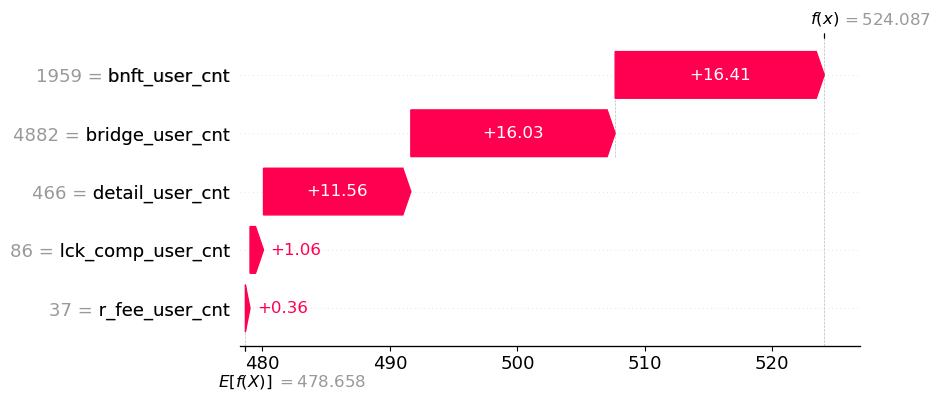

In [85]:
#가장 성과가 좋은 날 Water Fall
shap.plots.waterfall(shap_value[max_index])

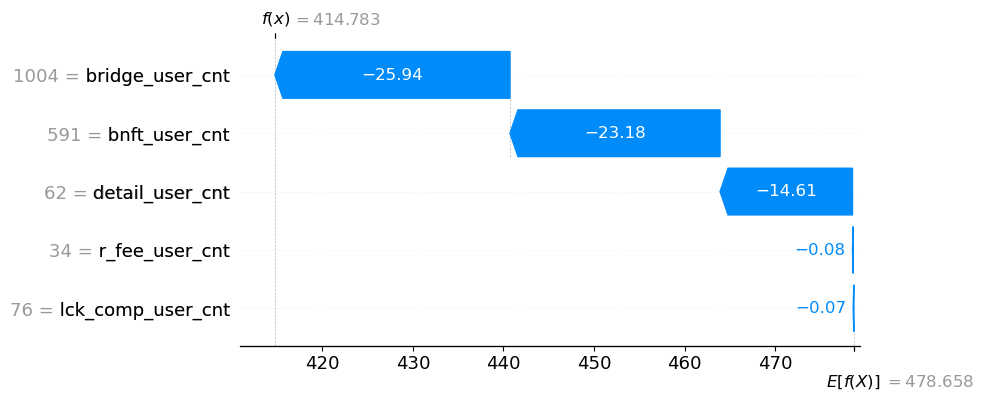

In [86]:
#가장 성과가 나쁜 날 Water Fall
shap.plots.waterfall(shap_value[min_index])